[link text](https://)

# Connect Google Drive
 Mount your google drive and add **phishingtxt.csv** into it to use

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 40.7 MB/s 


In [3]:
import tensorflow_hub as hub

import pandas as pd

import tensorflow_text as text

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

import numpy as np


#Change Path 
 Update path to where you place **phishingtxt.csv** in your google drive

In [4]:
# load data
df = pd.read_csv('/content/gdrive/MyDrive/Phishing/phishingtxt.csv')

In [5]:
df.head()

,Message,Label
0,IN W stars battle Tour DE France in W in W,1
1,"Dear eBay User , After fraud complaints from t...",1
2,Dear valued customer's Our records indicate th...,1
3,t submitted the correct information to update ...,1
4,Dear Key Bank customer's Please read this mess...,1


In [6]:
# check count and unique and top values and their frequency
df['Label'].value_counts()

1    2277
0     735
Name: Label, dtype: int64

In [7]:
# creating 2 new dataframe as df_ham , df_spam

df_phish = df[df['Label']== 1]

df_reg = df[df['Label']== 0]

print("Non Phishing Dataset Shape:", df_reg.shape)

print("Phishing Dataset Shape:", df_phish.shape)

Non Phishing Dataset Shape: (735, 2)
Phishing Dataset Shape: (2277, 2)


In [8]:
# downsampling ham dataset - take only random 747 example
# will use df_spam.shape[0] - 747
df_phish_downsampled = df_phish.sample(df_reg.shape[0])
df_phish_downsampled.shape

(735, 2)

In [9]:
# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_reg , df_phish_downsampled])

In [10]:
# displaying data - phish -1 , non-phishing-0
# shuffle the DataFrame rows
df_balanced = df_balanced.sample(frac = 1)
df_balanced
df_balanced['Label'].value_counts()

0    735
1    735
Name: Label, dtype: int64

In [11]:
# loading train test split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['Label'],
                                                    stratify = df_balanced['Label'])

In [12]:
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [13]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

In [14]:
# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [15]:
# check the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [16]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]


In [17]:
# compiling our model
model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [18]:
history = model.fit(X_train, y_train, epochs = 10)


Epoch 1/10
35/35 [==============================] - 39s 687ms/step - loss: 0.6347 - accuracy: 0.6534 - precision: 0.6771 - recall: 0.5862
Epoch 2/10
35/35 [==============================] - 24s 687ms/step - loss: 0.5497 - accuracy: 0.7559 - precision: 0.7650 - recall: 0.7387
Epoch 3/10
35/35 [==============================] - 24s 691ms/step - loss: 0.5010 - accuracy: 0.8058 - precision: 0.8377 - recall: 0.7586
Epoch 4/10
35/35 [==============================] - 24s 683ms/step - loss: 0.4566 - accuracy: 0.8430 - precision: 0.8449 - recall: 0.8403
Epoch 5/10
35/35 [==============================] - 24s 683ms/step - loss: 0.4264 - accuracy: 0.8512 - precision: 0.8787 - recall: 0.8149
Epoch 6/10
35/35 [==============================] - 24s 684ms/step - loss: 0.3941 - accuracy: 0.8757 - precision: 0.8764 - recall: 0.8748
Epoch 7/10
35/35 [==============================] - 24s 684ms/step - loss: 0.3753 - accuracy: 0.8784 - precision: 0.8854 - recall: 0.8693
Epoch 8/10
35/35 [================

In [19]:
# Evaluating performance
model.evaluate(X_test,y_test)

12/12 [==============================] - 9s 665ms/step - loss: 0.3337 - accuracy: 0.8913 - precision: 0.9186 - recall: 0.8587


[0.333651065826416, 0.8913043737411499, 0.9186046719551086, 0.8586956262588501]

In [20]:
# getting y_pred by predicting over X_text and flattening it
y_pred = model.predict(X_test)
y_pred = y_pred.flatten() # require to be in one-dimensional array , for easy manipulation

In [21]:
result = []
for y in y_pred: 
  if y > 0.5: 
    result.append(1)
  else: 
    result.append(0)

In [22]:
# importing confusion maxtrix

from sklearn.metrics import confusion_matrix , classification_report

# creating confusion matrix 

cm = confusion_matrix(y_test,result)

cm

array([[170,  14],
       [ 26, 158]])

In [23]:
# plotting as a graph - importing seaborn
import seaborn as sns

Text(33.0, 0.5, 'Actual')

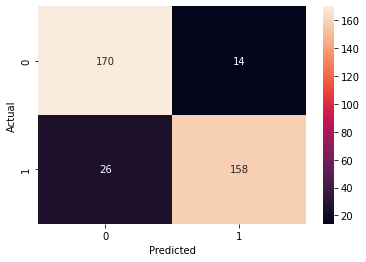

In [24]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [25]:
# printing classification report
print(classification_report(y_test , result))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       184
           1       0.92      0.86      0.89       184

    accuracy                           0.89       368
   macro avg       0.89      0.89      0.89       368
weighted avg       0.89      0.89      0.89       368



In [27]:
model.save('phishing-txt/txt-model')

INFO:tensorflow:Assets written to: phishing-txt/txt-model/assets


INFO:tensorflow:Assets written to: phishing-txt/txt-model/assets


In [28]:
new_model = tf.keras.models.load_model('phishing-txt/txt-model')